# Magnetic Fields

With improved code we will now analyse where, in the range between ballistic and diffuse motion, charged particles in a magnetic field are located, depending on the strength of the field.

To run multiple simulation we arrange our code in functions. These functions we will then put into a separate python file and import on further simulations.

In [1]:
%matplotlib notebook

from crpropa import *
from pylab import *
from mpl_toolkits.mplot3d import axes3d
from collections import defaultdict
from scipy.optimize import curve_fit
import numpy as np

num_candidates = 300
EMin = 1 * EeV
EMax = 1 * EeV
num_samples = 200
max_trajectory_length = 100 * Mpc
grid_size = 256
grid_spacing = 30 * kpc
Brms = 10 * nG
lMin = 100 * kpc
lMax = 1000 * kpc
alpha = -11./3.

# returns list of candidates
def create_candidates(num_candidates, EMin, EMax):
    source = Source()
    source.add(SourceParticleType(nucleusId(1, 1)))
    source.add(SourcePowerLawSpectrum(EMin, EMax, -1))
    source.add(SourceIsotropicEmission())
    source.add(SourcePosition(Vector3d(0, 0, 0)*Mpc))
    candidates = []
    for i in range(0,num_candidates):
        candidates.append(source.getCandidate())
    return candidates

# returns propagation module with B field
def create_prop(grid_size, grid_spacing, Brms, lMin, lMax, alpha):
    vgrid = VectorGrid(Vector3d(0), grid_size, grid_spacing)
    initTurbulence(vgrid, Brms, lMin, lMax, alpha)
    Bfield = MagneticFieldGrid(vgrid)
    prop = PropagationCK(Bfield)
    return prop

# simulates one B field setting, return data
def sim(num_candidates, num_samples, max_trajectory_length, EMin, EMax, grid_size, grid_spacing, Brms, lMin, lMax, alpha):
    sync_step = max_trajectory_length / num_samples
    candidates = create_candidates(num_candidates, EMin, EMax)
    prop = create_prop(grid_size, grid_spacing, Brms, lMin, lMax, alpha)
    data = np.empty([0,4])
    for s in range(1,num_samples+1):
        stop = MaximumTrajectoryLength(s * sync_step)
        for c in candidates:
            c.setActive(True);
            while c.isActive():
                prop.process(c.get())
                stop.process(c.get())
            pos = c.current.getPosition()
            data = np.append(data, [[s * sync_step, pos.getX(), pos.getY(), pos.getZ()]], axis=0)
    # data in Mpc
    data = data / Mpc;
    return data

def plot_trajectory(data):
    x, y, z = data[:,1], data[:,2], data[:,3]
    fig = plt.figure(figsize=(9, 5))#plt.figaspect(0.5))
    ax = fig.gca(projection='3d')# , aspect='equal'
    ax.scatter(x,y,z, 'o', lw=0)
    ax.set_xlabel('x [Mpc]', fontsize=18)
    ax.set_ylabel('y [Mpc]', fontsize=18)
    ax.set_zlabel('z [Mpc]', fontsize=18)
    ax.set_xlim((-10, 10))
    ax.set_ylim((-10, 10))
    ax.set_zlim((-10, 10))
    ax.xaxis.set_ticks((-10, -5, 0, 5, 10))
    ax.yaxis.set_ticks((-10, -5, 0, 5, 10))
    ax.zaxis.set_ticks((-10, -5, 0, 5, 10))
    show()
    return

def fit_func(x, a, b):
    return a*(x**b)

def plot_rms(data, plot_title=''):
    grouped = defaultdict(list)
    d = []
    r_sq = []
    d_end = 0
    #print(data.dtype.names)
    for di, X, Y, Z in data:
        grouped[di].append(X**2 + Y**2 + Z**2)
    for di in grouped: 
        d.append(di)
        r_sq.append(np.mean(grouped[di]))
        d_end = max(d_end, di)
    print('After last step:')
    print('r_min   = ' + str(sqrt(np.min(grouped[d_end]))))
    print('r_max   = ' + str(sqrt(np.max(grouped[d_end]))))
    r_avg = np.mean(sqrt(grouped[d_end]))
    print('< r >   = ' + str(r_avg))
    print('< r >²  = ' + str(r_avg**2))
    r_sq_avg = np.mean(grouped[d_end])
    print('< r² >  = ' + str(r_sq_avg))
    print('sigma_r = ' + str(sqrt(abs(r_sq_avg - r_avg**2))))

    popt, pcov = curve_fit(fit_func, d, r_sq, bounds=(0, [4.0, 2.0]))
    D = popt[0]
    exponent = popt[1]
    print()
    print('Over all data points:')
    print('D       = ' + str(D))
    print('exponent= ' + str(exponent))
    print()
    print('r²     ~= ' + str(D) + ' d ^ ' + str(exponent))
    
    figure(figsize=(9, 5))
    title(plot_title)
    plot(d, r_sq, 'b-')
    plot(d, fit_func(d, D, exponent), 'b:', label='%.3f d ^ %.3f' % tuple(popt))
    grid()
    ylabel('$<$r²$>$ [Mpc²]')
    xlabel('d [Mpc]')
    legend()
    show()    
    return

Now we can run the simulation with a few lines.

<IPython.core.display.Javascript object>


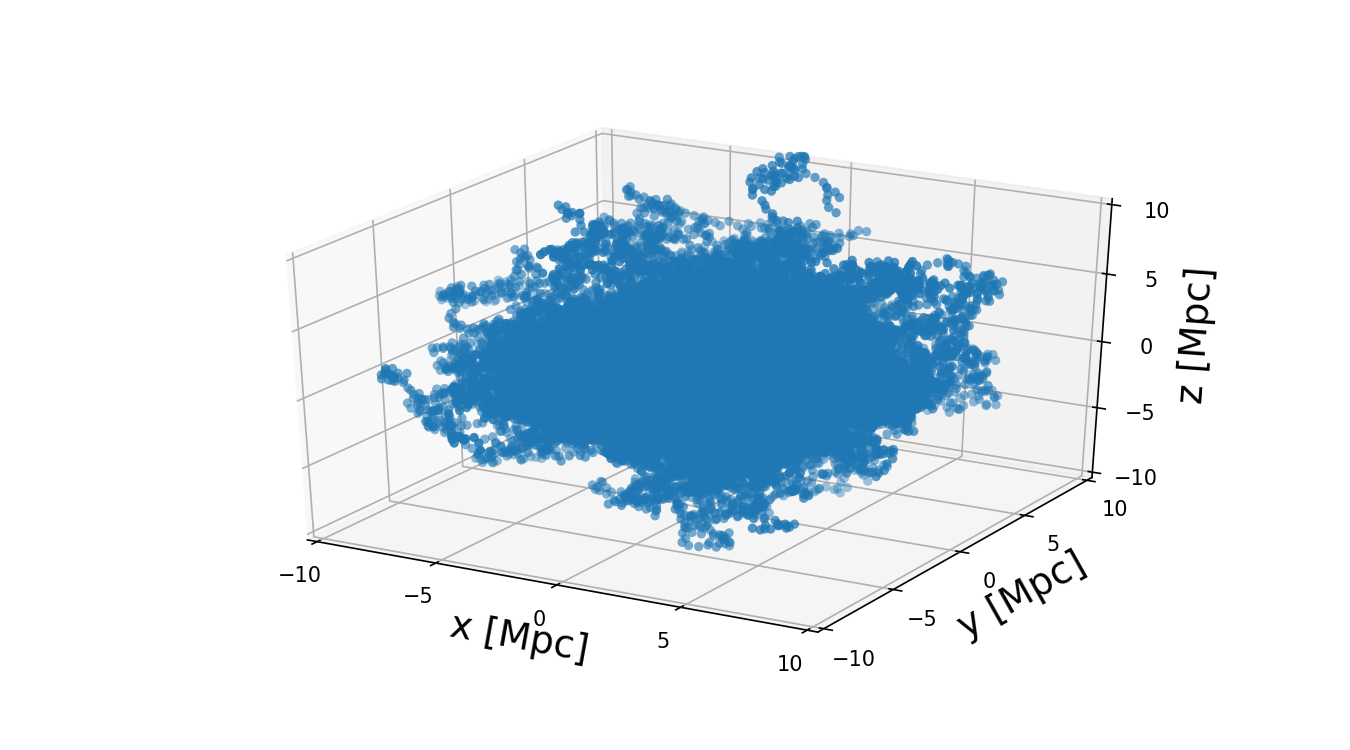

After last step:
r_min   = 1.08617975449
r_max   = 14.2152571393
< r >   = 6.44914708133
< r >²  = 41.5914980766
< r² >  = 48.6371415253
sigma_r = 2.65436309661

Over all data points:
D       = 0.429983199575
exponent= 1.02935513872

r²     ~= 0.429983199575 d ^ 1.02935513872


<IPython.core.display.Javascript object>


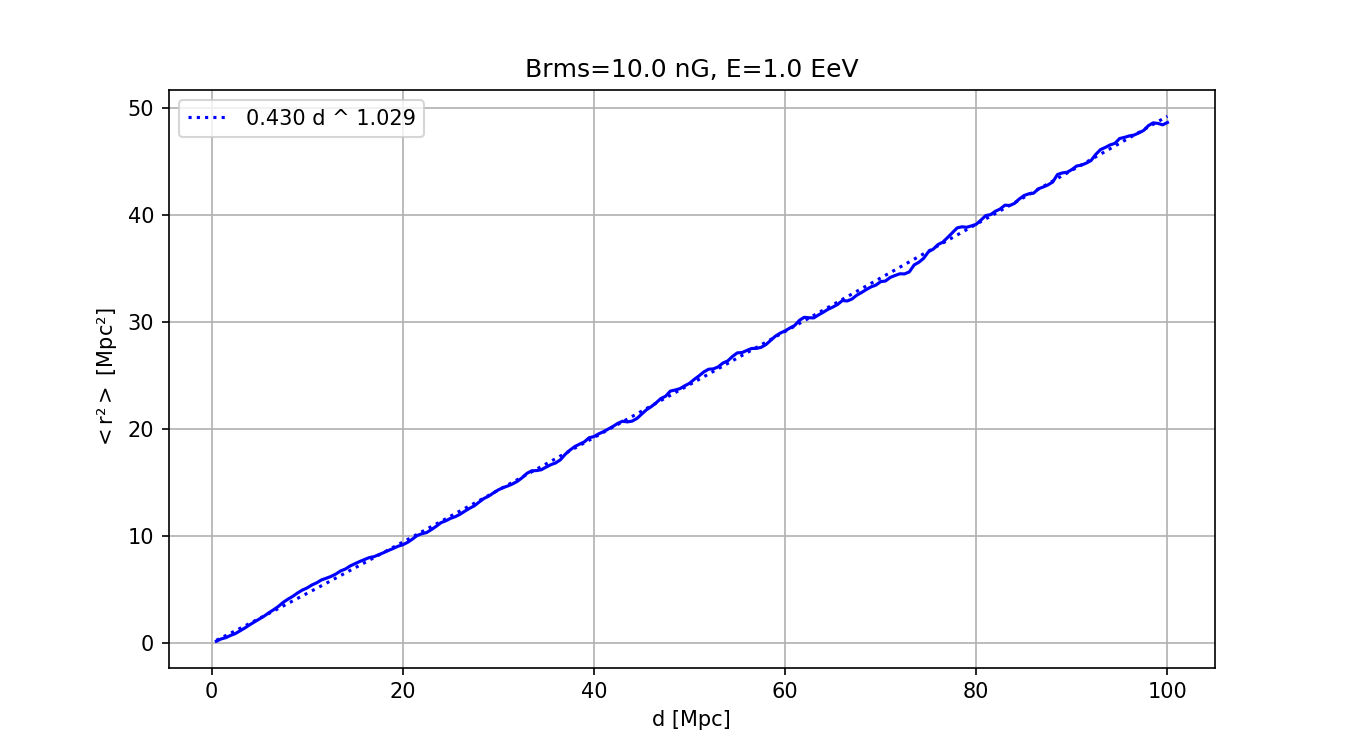

In [2]:
# use default settings
data = sim(num_candidates, num_samples, max_trajectory_length, EMin, EMax, grid_size, grid_spacing, Brms, lMin, lMax, alpha)
plot_title = 'Brms=' + str(Brms / nG) + ' nG, E=' + str(EMin / EeV) + ' EeV'
plot_trajectory(data)
plot_rms(data, plot_title)

And then another setting with stronger B field.

<IPython.core.display.Javascript object>


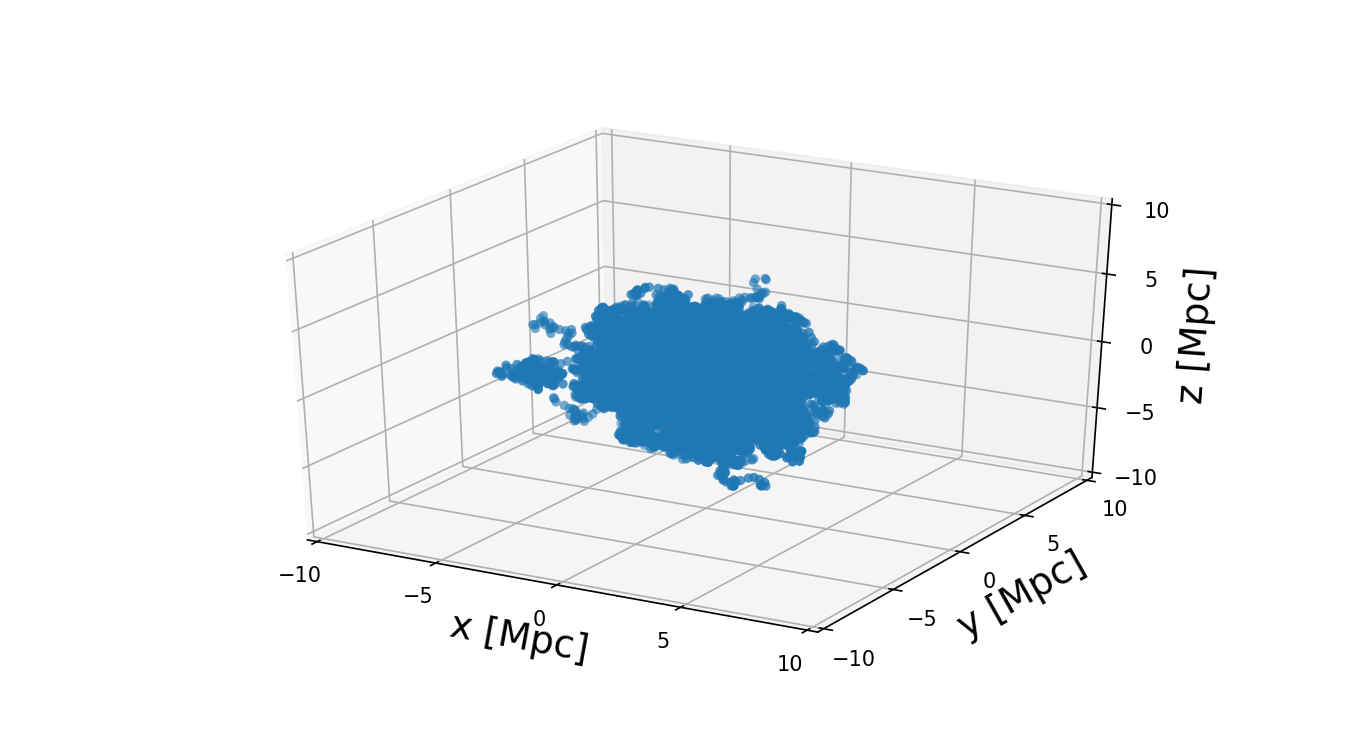

After last step:
r_min   = 0.67098256333
r_max   = 7.88535564647
< r >   = 3.39929830097
< r >²  = 11.555228939
< r² >  = 13.4414388244
sigma_r = 1.37339356537

Over all data points:
D       = 0.126997352076
exponent= 1.01270205864

r²     ~= 0.126997352076 d ^ 1.01270205864


<IPython.core.display.Javascript object>


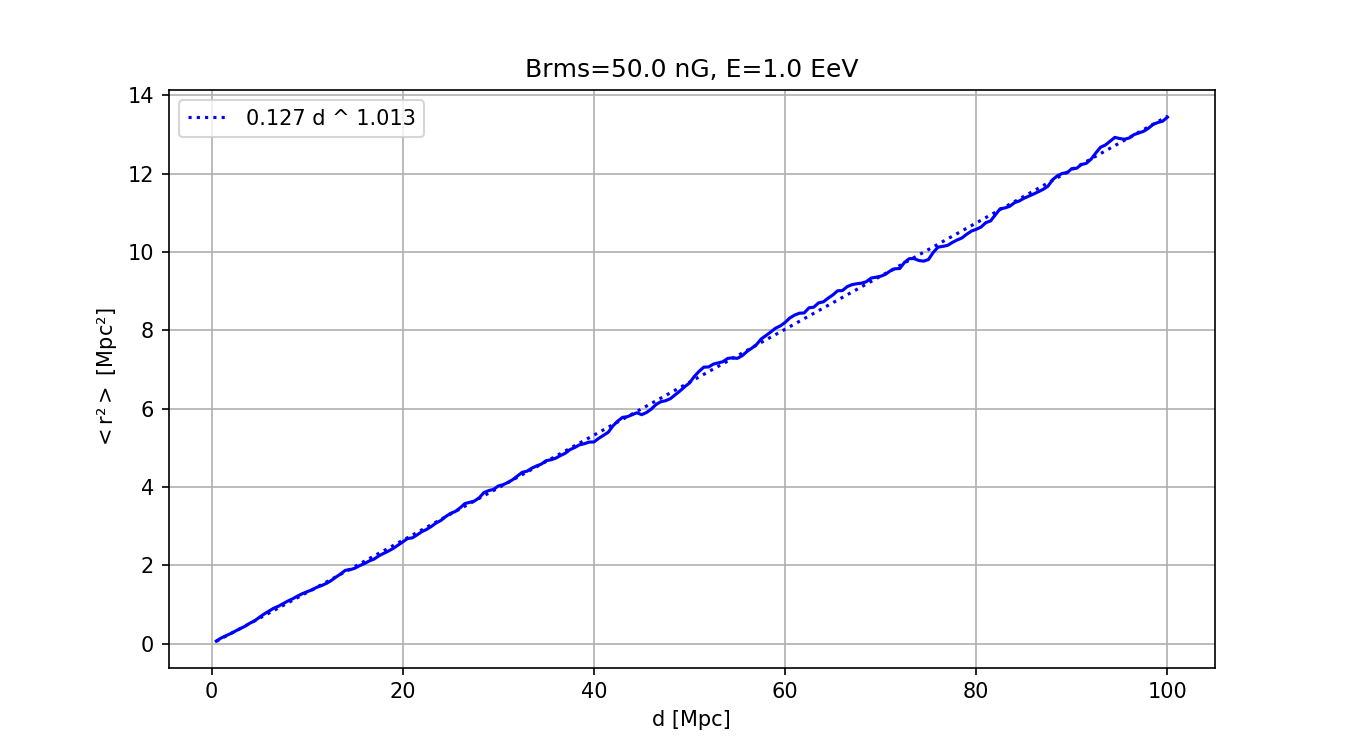

In [3]:
Brms = 50 * nG
data = sim(num_candidates, num_samples, max_trajectory_length, EMin, EMax, grid_size, grid_spacing, Brms, lMin, lMax, alpha)
plot_title = 'Brms=' + str(Brms / nG) + ' nG, E=' + str(EMin / EeV) + ' EeV'
plot_trajectory(data)
plot_rms(data, plot_title)

Now theory is if we multiplied the B field by 5 and now multiply the particle energy by 5 as well, results shall look like initial behaviour.

<IPython.core.display.Javascript object>


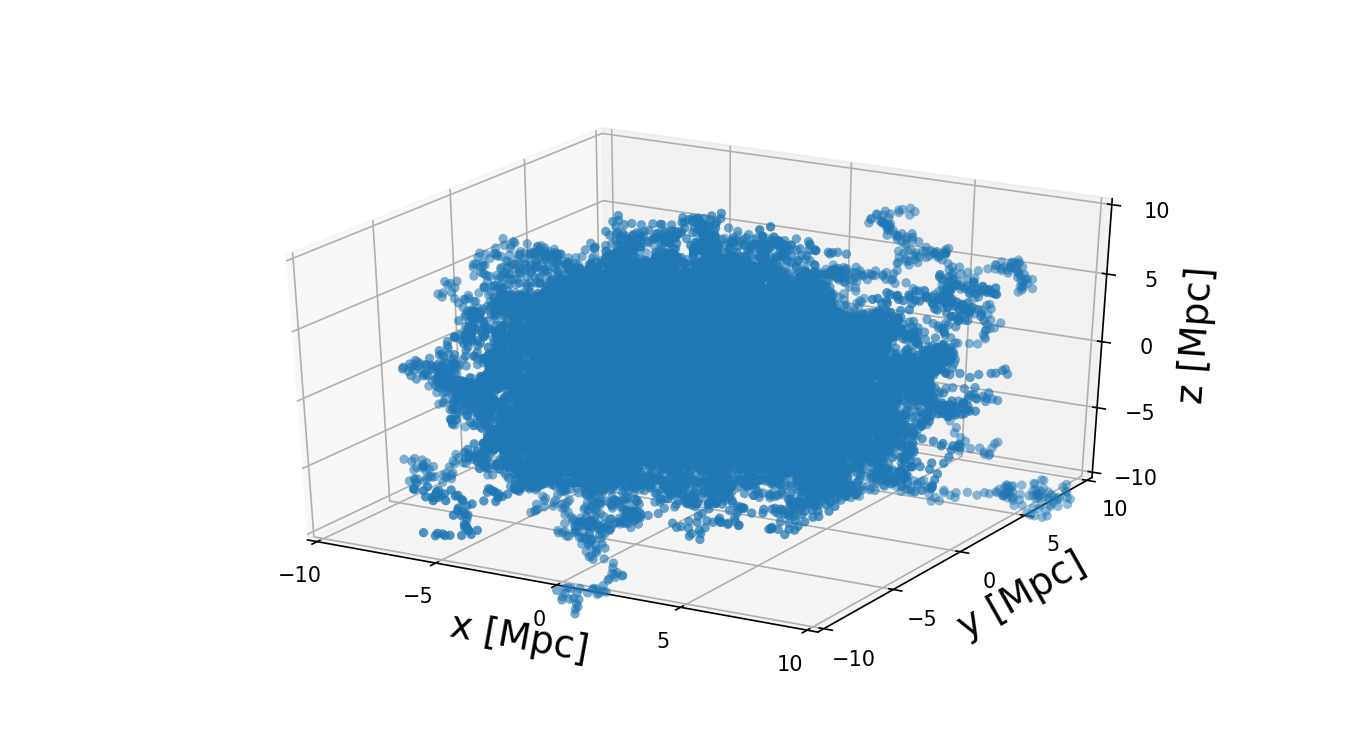

After last step:
r_min   = 0.952066291723
r_max   = 16.0688170103
< r >   = 6.95774690548
< r >²  = 48.4102420007
< r² >  = 57.0453367113
sigma_r = 2.93855316621

Over all data points:
D       = 0.456495590748
exponent= 1.04241069027

r²     ~= 0.456495590748 d ^ 1.04241069027


<IPython.core.display.Javascript object>


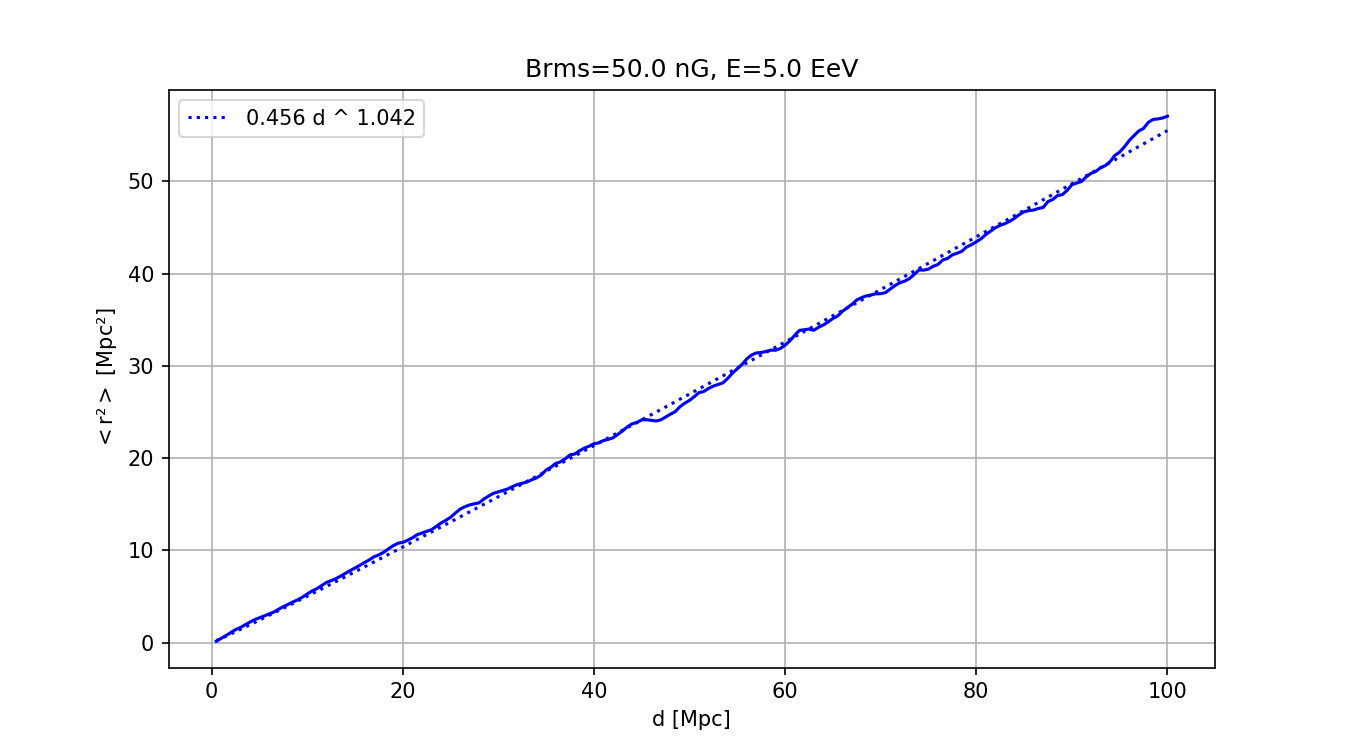

In [4]:
Brms = 50 * nG
EMin = 5 * EeV
EMax = 5 * EeV
data = sim(num_candidates, num_samples, max_trajectory_length, EMin, EMax, grid_size, grid_spacing, Brms, lMin, lMax, alpha)
plot_title = 'Brms=' + str(Brms / nG) + ' nG, E=' + str(EMin / EeV) + ' EeV'
plot_trajectory(data)
plot_rms(data, plot_title)

We can see it did return near the initial value. Next we will have a look at the variance of those results, simulating same settings more often.